In [1]:
#| default_exp ml_classification

# Water pixels classification

Steps :
1. Collect water pixels into table (consider negative buffer for mroe accuracy)  
2. consider - filter pixels based on the values I found in task 2  
3. create dataframe  
4. split x,y,train,test and train model  
5. evaluate the model

In [2]:
#|hide
from nbdev.showdoc import *

In [3]:
#|export
#|hide

import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,ConfusionMatrixDisplay


from flood_exercise import utils_func
from flood_exercise import const_vals as CONST

C:\Users\USER\AppData\Local\Temp\ipykernel_12068\2464301796.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
#|export

class classification_pixels():
  
  def __init__(self,
               path_labels_str : str , #path to the labeled images
               path_imgs_str : str , #path to S2 images to be used for train
               target_col : str , #name of the target attribute in the dataframe. Will be used for model training
               cols_to_drop : list = [None] , # list of columns to be dropped from the dataframe. These columns won't be used to train the model. 
               test_size : float=CONST.TEST_SIZE , #size of test data
               random_state : int = CONST.RANDOM_STATE , #random state , deafult value is set in Cconst_vals module
               n_jobs : int=CONST.N_JOBS,

               ):
    
    self.target_col = target_col
    self.cols_to_drop = cols_to_drop
    self.test_size = test_size
    self.random_state = random_state
    
    self.path_labels = utils_func.load_list_paths(path = path_labels_str , filter_file = True)
    self.path_imgs = utils_func.load_list_paths(path = path_imgs_str , filter_file= True)


    #collect pixels into dataframe 
    self.df_res = self._collect_pixels_to_dataframe_()

    # split into train and test data for ML model
    self.x_train, self.x_test, self.y_train, self.y_test=self._prepare_dataframe_for_train_()

    self.best_model = self._train_ml_classification_()

    self._evaluate_classification()




  def _collect_pixels_to_dataframe_(self):
    dfs_pixels = []

    for label_path in self.path_labels:
      id_path = label_path.split(CONST.SPLIT_TILES_NAMES_STR1)[-1].split(CONST.SPLIT_TILES_NAMES_STR2)[1]
      
      #find the matching S2 image
      s2_img_path = [x for x in self.path_imgs if id_path in x]
      
      if len(s2_img_path)==1:

        s2_img = rasterio.open(s2_img_path[0]).read()
        cols = rasterio.open(s2_img_path[0]).descriptions + rasterio.open(label_path).descriptions
        cols = [str(x) for x in cols]
        label_img = rasterio.open(label_path).read()

        stacked_img = np.concatenate((s2_img, label_img), axis=0)
        
        df_pixels = pd.DataFrame(stacked_img.reshape([stacked_img.shape[0],-1]).T)
        df_pixels.columns = cols
        dfs_pixels.append(df_pixels)

      else:
        continue
      
      
      df_res = pd.concat(dfs_pixels)

      return df_res
    
  
  def _prepare_dataframe_for_train_(self):
    
    #drop columns that are not relevant for the training (defined by user)
    
    if self.cols_to_drop[0] != None:

      try:
        self.df_res=self.df_res.drop(self.cols_to_drop,axis=1)

      except Exception as e:
        print(f'Could not drop the columns {self.cols_to_drop} with error:{e}')
        

    #drop null values
    self.df_res.dropna(axis=0,inplace=True)

    # add 1 to class column , as it has -1 values 

    self.df_res[self.target_col] = self.df_res[self.target_col] + 1

    x = self.df_res.drop(self.target_col,axis=1)
    y = self.df_res[self.target_col].values
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size = self.test_size, 
                                                        random_state = self.random_state)

    return x_train, x_test, y_train, y_test
    

  def _train_ml_classification_(self):
    classifier = xgboost.XGBClassifier()
    
    XGB_random = RandomizedSearchCV(estimator = classifier, 
                                   param_distributions = CONST.RANDOM_GRID_XGB,
                                   n_iter = CONST.N_ITERATIONS_XGB,
                                   cv = CONST.CV_XGB, 
                                   verbose=CONST.VERBOSE , 
                                   random_state=CONST.RANDOM_STATE , 
                                   n_jobs = CONST.N_JOBS)
                   
    #fit model 
    XGB_random.fit(self.x_train, self.y_train)

  #best params
    self.best_params = XGB_random.best_params_
    print(f'best params : {self.best_params}')

    best_model =xgboost.XGBClassifier(**self.best_params)

    best_model.fit(self.x_train, self.y_train)


    return best_model
  
  def _evaluate_classification(self):
    
    y_pred = self.best_model.predict(self.x_test)

    # Calculate accuracy
    accuracy = accuracy_score(self.y_test, y_pred)
    print("Accuracy:", accuracy)

    #feature importance
    importance_scores = self.best_model.feature_importances_
    feature_names = self.x_test.columns.tolist()

        # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance_scores)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.show()


    cm = confusion_matrix(self.y_test, y_pred, normalize='true')
    cmd = ConfusionMatrixDisplay(cm,display_labels=['0','1','2'])
    cmd.plot(cmap='Blues')
    plt.show()   

 




  


    

Could not drop the columns ['qc'] with error:"['qc'] not found in axis"
Fitting 3 folds for each of 100 candidates, totalling 300 fits
best params : {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.01, 'eta': 1, 'alpha': 0.5}
Accuracy: 0.9964599609375


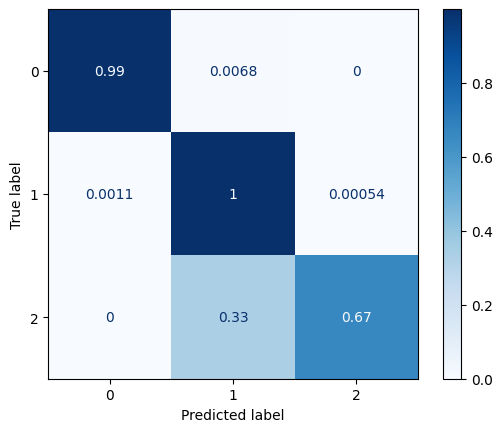

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,None
0,1518,1233,1186,875,1256,2642,3335,3061,3561,342,35,2394,1158,1
1,1518,1239,1194,897,1256,2642,3335,2887,3561,342,35,2394,1158,1
2,1517,1251,1253,933,1381,2806,3312,3115,3806,360,33,2563,1387,1
3,1517,1255,1247,936,1381,2806,3312,3181,3806,360,33,2563,1387,1
4,1517,1228,1197,897,1288,2498,3048,2898,3362,360,33,2493,1375,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262139,1681,1392,1390,1082,1468,2821,3442,3195,3831,481,133,2374,1172,1
262140,1681,1390,1379,1099,1468,2821,3442,3044,3831,481,133,2374,1172,1
262141,1681,1373,1372,1086,1439,2680,3159,2991,3537,481,133,2318,1195,1
262142,1681,1363,1335,1060,1439,2680,3159,2917,3537,481,133,2318,1195,1


In [5]:
instance = classification_pixels(path_imgs_str=r"D:\git\flood_exercise\S2",
                                 path_labels_str=r"D:\git\flood_exercise\S2_HANDLABELED",
                                 target_col = 'None',
                                 cols_to_drop= ['qc'],
                                 test_size= 0.25,
                                 random_state = 42,

                                 )
instance.df_res